In [ ]:
#释放GPU内存
'''
!apt install psmisc
!sudo fuser /dev/nvidia*
!kill -9 63'''

'\n!apt install psmisc\n!sudo fuser /dev/nvidia*\n!kill -9 63'

In [1]:
!nvidia-smi #查看GPU配置
import os
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive'
os.chdir(path)
os.listdir()
#!ls
import json
import csv
import pandas as pd
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt
% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

Thu Mar  4 13:09:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip3 install pytorch-pretrained-bert

     |████████████████████████████████| 133kB 7.7MB/s 
     |████████████████████████████████| 133kB 13.4MB/s 
     |████████████████████████████████| 7.3MB 13.1MB/s 
     |████████████████████████████████| 71kB 12.1MB/s 
ERROR: botocore 1.20.20 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [3]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
'''报错ImportError: cannot import name 'IPV6_ADDRZ_RE'     !pip install -Iv botocore==1.17'''

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 903111.76B/s]


In [4]:
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
model.to(device)
print(device)

100%|██████████| 407873900/407873900 [00:11<00:00, 34935977.87B/s]


cuda


In [ ]:
def extract_tokens_from_binary_parse(text):
  text = text.rstrip().strip()#去掉句首尾空格
  #text = '[CLS] ' + text + ' [SEP]' 
  return text.replace('(', ' ').replace(')', ' ').replace('-LRB-', '(').replace('-RRB-', ')').split()

def getEntailment2List(path,l):
  source = []
  target = []
  for i, line in enumerate(open(path)):#enumerate给每行/每个字典加了一个数字编号,每一行都是一个单独的字典
    data = json.loads(line)#一个data就是一行数据
    #json.loads将已编码的JSON字符串解码为Python对象,JSON对象无法正常,即line无法当字典来正常使用。此处在for循环中，依次对每行进行解码
    label = data['gold_label']#取出该行的标签#本质上是从字典中取出key->value,'gold_label'是key。
    if label == l:
      s1 = ' '.join(extract_tokens_from_binary_parse(data['sentence1_binary_parse']))
      s2 = ' '.join(extract_tokens_from_binary_parse(data['sentence2_binary_parse']))    
      source.append(s1)
      target.append(s2)
  return source,target

In [ ]:
data_path = './Colab Notebooks/Entailment_generation/snli_1.0/'
e_list = getEntailment2List(os.path.join(data_path,'snli_1.0_train.jsonl'),'entailment')
#n_list = getEntailment2List(os.path.join(data_path,'snli_1.0_train.jsonl'),'neutral')

In [5]:
def getPre(texts):

        
  tokenized_texts = []
  indexed_tokens = []
  segments_ids = []
  tokens_tensors = []
  segments_tensors = []
  for i in range(len(texts)):
    #print(texts[i])

    tokenized_text = tokenizer.tokenize("[CLS] " + texts[i] + " [SEP]")
    tokenized_texts.append(tokenized_text)
    #print(tokenized_texts[i])

    indexed_token = tokenizer.convert_tokens_to_ids(tokenized_texts[i])
    indexed_tokens.append(indexed_token)
    #print(indexed_tokens[i])
    
    segments_id = [1] * len(tokenized_texts[i])
    segments_ids.append(segments_id)
    #print(segments_ids[i])

    tokens_tensor = torch.tensor([indexed_tokens[i]]).to(device)
    tokens_tensors.append(tokens_tensor)
    print(tokens_tensors[i])

    segments_tensor = torch.tensor([segments_ids[i]]).to(device)
    segments_tensors.append(segments_tensor)
    print(segments_tensors[i])

    
  return tokens_tensors, segments_tensors

In [6]:
def getTokenEmbed(texts):

  tokens_tensors, segments_tensors = getPre(texts)

  encoded_layers = []
  token_embeddings = []

  for i in range(len(texts)):
    with torch.no_grad():
      encoded_layer, _ = model(tokens_tensors[i], segments_tensors[i])
      encoded_layers.append(encoded_layer)
    layer_i = 0
    batch_i = 0
    token_i = 0  
    #print("Number of layers:", len(encoded_layers[i]))  
    #print("Number of batches:", len(encoded_layers[i][layer_i]))
    #print("Number of tokens:", len(encoded_layers[i][layer_i][batch_i]))
    #print("Number of hidden units:", len(encoded_layers[i][layer_i][batch_i][token_i]))
    
    #print('     Type of encoded_layers: ', type(encoded_layers[i]))# `encoded_layers` is a Python list. 
    #print('Tensor shape for each layer: ', encoded_layers[i][0].size())# Each layer in the list is a torch tensor.

    # Concatenate the tensors for all layers. We use `stack` here to
    # create a new dimension in the tensor.
    token_embedding = torch.squeeze(torch.stack(encoded_layers[i], dim=0),dim=1).permute(1,0,2).to(device)
    token_embeddings.append(token_embedding)
    #print(token_embeddings[i].size())

    #print()
    #print()
  
  return token_embeddings

In [7]:
def getSenEmbed(texts):

  token_embeddings = getTokenEmbed(texts)
  token_vecs_sums = []
  sentences_embedding = []
  for i in range(len(texts)):
    token_vecs_sum = []
    # `token_embeddings` is a [seq_len x 12 x 768] tensor.
    # For each token in the sentence...
    for token in token_embeddings[i]:

        # `token` is a [12 x 768] tensor 
        sum_vec = torch.sum(token[-4:], dim=0).cpu().numpy().tolist()# Sum the vectors from the last four layers.

        # Use `sum_vec` to represent `token`.
        token_vecs_sum.append(sum_vec)

    token_vecs_sum=torch.tensor(token_vecs_sum)
    token_vecs_sums.append(token_vecs_sum)
    #print(token_vecs_sums[i].size())

    '''if (i==4):
      t=token_vecs_sums[i].numpy().tolist()
      for j in range(1):
        t.append(t[5])
      token_vecs_sums[i]=torch.tensor(t)'''

    #print(token_vecs_sums[i].size())
    sentence_embedding = torch.mean(token_vecs_sums[i], dim=0).to(device)
    sentences_embedding.append(sentence_embedding)
    #print(sentence_embedding.size())


    #print()
 
  #print("sentences_embedding",len(sentences_embedding))
  return sentences_embedding

In [34]:
print(a1)

[0.9047503471374512]


In [33]:
a1 = getScores(["Two children in hats play in an open , rocky field ."], ["The children are playing in a rocky field ."])
#a2 = getScores(["A dog drops a red disc on a beach ."], ["A dog drops a red disc　."])
#print(a1,a2)

tensor([[  101,  2048,  2336,  1999, 16717,  2377,  1999,  2019,  2330,  1010,
          6857,  2492,  1012,   102]], device='cuda:0')
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')
tensor([[ 101, 1996, 2336, 2024, 2652, 1999, 1037, 6857, 2492, 1012,  102]],
       device='cuda:0')
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')


In [8]:
def getScores(t1,t2):
  
  s1 = getSenEmbed(t1)
  s2 = getSenEmbed(t2)
  
  #scores1 = []
  #scores2 = []
  cs = []
  #attns = []
  for i in range(len(t1)): 
    
    c = torch.cosine_similarity(s1[i],s2[i],dim=0).cpu().numpy().tolist()
    cs.append(c)
    #s1n = torch.norm(s1[i],2, dim=None, keepdim=False, out=None, dtype=None)
    #s2n = torch.norm(s2[i],2, dim=None, keepdim=False, out=None, dtype=None) 
    #attn = torch.mul(s1[i],s2[i]).sum().cpu().numpy()
    #score1 = (attn/s1n/s1n).numpy()
    #score2 = (attn/s2n/s2n).numpy()
    #attns.append(attn)
    #scores1.append(score1)
    #scores2.append(score2)    
  
  
  #scores1 = torch.tensor(scores1).mean()
  #scores2 = torch.tensor(scores2).mean()
  #cs = torch.tensor(cs).mean()
  #attns = torch.tensor(attns).mean()
    
  return cs #, attns, scores1, scores2


In [ ]:
print(len(e_list[0]))
i=11
print(os.path.join(data_path,str(i)+'train_cosine.csv'))

183416
./Colab Notebooks/Entailment_generation/snli_1.0/11train_cosine.csv


In [ ]:
total_cosine_list = []
for i in range(1834):
 cosine_list = getScores(e_list[0][i*100:(i+1)*100],e_list[1][i*100:(i+1)*100])
 total_cosine_list = total_cosine_list + cosine_list
 print(i)

cosine_list = getScores(e_list[0][183400:],e_list[1][183400:])
total_cosine_list = total_cosine_list + cosine_list


data_path = './Colab Notebooks/Entailment_generation/snli_1.0/'
header = ['cosine_similarity']
list_write = pd.DataFrame(columns=header,data=cosine_list)
list_write.to_csv(os.path.join(data_path,'train_cosine.csv'))

print(torch.tensor(total_cosine_list).mean())

In [ ]:
data_path = './Colab Notebooks/Entailment_generation/snli_1.0/'
if 0:
  header = ['cosine_similarity']
  list_write = pd.DataFrame(columns=header,data=total_cosine_list)
  list_write.to_csv(os.path.join(data_path,'train_cosine.csv'))

In [ ]:
import csv,os
with open(os.path.join(data_path,'train_cosine.csv') ,'r') as f:
  next(f)
  reader = csv.reader(f)
  cosine_list = [row[1] for row in reader]
  cosine_list_float = [float(column) for column in cosine_list]

In [ ]:
print(torch.tensor(cosine_list_float).mean())

tensor(0.8030)


In [ ]:
for i in range(183416):
  if cosine_list_float[i] >= 0.9 :
    if cosine_list_float[i] < 0.92 :
      print(i,cosine_list_float[i],e_list[0][i])
      print(i,cosine_list_float[i],e_list[1][i]) 
      print()
  
  if i >1000:
    break


60 0.916510820388794 Bicyclists waiting at an intersection .
60 0.916510820388794 Bicyclists waiting their turn to cross .

100 0.9174861907958984 A foreign family is walking along a dirt path next to the water .
100 0.9174861907958984 A family walks along a dirt path .

133 0.9036214351654053 A guy performing a bicycle jump trick for an audience .
133 0.9036214351654053 a guy is performing a bike trick

139 0.9047503471374512 Two children in hats play in an open , rocky field .
139 0.9047503471374512 The children are playing in a rocky field .

141 0.9188957810401917 Man in gold pants looking at the camera .
141 0.9188957810401917 Man looking at the camera .

146 0.9000919461250305 A young girl sitting at a table with a bowl on her head
146 0.9000919461250305 A young girl has a bowl on her head

155 0.9168713092803955 A man stare at a passing couple while walking down the block .
155 0.9168713092803955 A man stares at a passing couple .

166 0.9084240794181824 Tourists waiting at a tr

In [ ]:
print(picture[1])

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


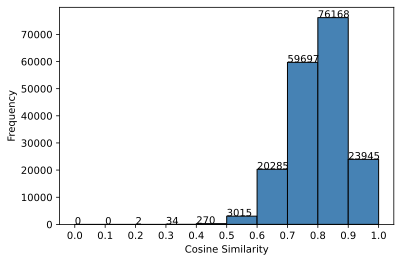

In [ ]:
%config InlineBackend.figure_format='svg'#在默认设置的matplotlib中图片分辨率不是很高，可以通过设置矢量图的方式来提高图片显示质量

bins = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
picture = plt.hist(cosine_list_float,bins=bins,color='steelblue',edgecolor='black')#参数bin指明切分区间，左开右闭区间。
plt.xticks(np.arange(0, 1.1, 0.1))

plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')


for a,b in zip(picture[1], (int(y_label) for y_label in picture[0])):
  plt.text(a,b,b)
#plt.savefig(data_path)



In [ ]:
Beijing = token_vecs_sums[0][5]#Beijing
China = token_vecs_sums[1][5]#China
Shanghai = token_vecs_sums[3][4]
two_words(Beijing,China)
two_words(Beijing,Shanghai)
two_words(Shanghai,China)

def two_words(a,b):
  a = a
  b = b

  al=torch.norm(a,2)
  bl= torch.norm(b,2)
  
  c = torch.cosine_similarity(a,b,dim=0)
  ab = torch.mul(a,b).sum()
  print("cos",c)
  print("ab/a/a",ab/al/al)
  print("ab/b/b",ab/bl/bl)
  print()

